In [498]:
import pandas as pd

In [499]:
hotels = pd.read_csv('https://www.dropbox.com/s/nex7vvntrhfj9h0/hotels.csv?dl=0')

In [500]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')

In [501]:
dupl_columns = list(hotels.columns)

dupl = hotels.duplicated(subset=dupl_columns)
h_duplicates = hotels[dupl]
print(f'Found duplicates:{h_duplicates.shape[0]}')

Found duplicates:307


In [502]:
hotels = hotels.drop_duplicates(subset=dupl_columns)
print(f'Total: {hotels.shape[0]}')

Total: 386496


In [503]:
susp10 = hotels[hotels['reviewer_score']==10]
susp10 = susp10[susp10['review_total_negative_word_counts']>10]
susp10 = susp10[susp10['review_total_positive_word_counts']==0]
susp10.head()

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
111,Lakeside Way Brent London HA9 0BU United Kingdom,1427,2016-04-10,8.8,Hilton London Wembley,United Kingdom,There was not enough coffee and milk in the room,11,4305,No Positive,0,1,10.0,"[' Leisure trip ', ' Couple ', ' King Guest Ro...",480 day,51.557696,-0.283526
448,40 trinity square City of London London EC3N 4...,832,2016-12-19,9.1,citizenM Tower of London,United Kingdom,Rooms are a little basic but rest of the plac...,18,4672,No Positive,0,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Double...",227 day,51.510237,-0.076443
593,252 High Holborn Holborn Camden London WC1V 7E...,256,2015-08-23,9.4,Rosewood London,United Kingdom,The only downside was the air con for the cor...,21,1008,No Positive,0,1,10.0,"[' Leisure trip ', ' Family with young childre...",711 day,51.517330,-0.118097
1127,Scarsdale Place Kensington Kensington and Chel...,1831,2015-09-17,8.1,Copthorne Tara Hotel London Kensington,New Zealand,I think in this era of 2015 WIFI should be av...,67,7105,No Positive,0,10,10.0,"[' Leisure trip ', ' Couple ', ' Superior Plus...",686 day,51.499046,-0.191707
1173,Rec Comtal 16 18 Ciutat Vella 08003 Barcelona ...,211,2017-03-21,8.8,Catalonia Born,United Kingdom,Everything was perfect about the hotel howeve...,28,2094,No Positive,0,1,10.0,"[' Leisure trip ', ' Couple ', ' Double Room '...",135 day,41.389692,2.179866


In [504]:
# hotels = pd.concat([hotels, susp10, susp10]).drop_duplicates(keep=False)

In [505]:
import numpy as np
import pycountry

def do_fuzzy_search(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

iso_map = {country: do_fuzzy_search(country) for country in hotels["reviewer_nationality"].unique()}
hotels["country_code"] = hotels['reviewer_nationality'].map(iso_map)

In [506]:
miss = hotels[hotels['country_code'].isnull()]
miss['reviewer_nationality'].value_counts()

 Abkhazia Georgia                     116
 Macau                                 77
 Palestinian Territory                 39
 Cura ao                               29
 Ivory Coast                           15
 Turks Caicos Islands                  12
 Antigua Barbuda                       12
 U S Virgin Islands                    11
 Swaziland                              7
 Laos                                   6
 St Maarten                             6
 Democratic Republic of the Congo       6
 Falkland Islands Malvinas              5
 Crimea                                 4
 East Timor                             4
 Central Africa Republic                3
 St Pierre and Miquelon                 2
 Cocos K I                              2
 Saint Vincent Grenadines               1
 Bonaire St Eustatius and Saba          1
 Svalbard Jan Mayen                     1
 Saint Barts                            1
Name: reviewer_nationality, dtype: int64

In [507]:
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Abkhazia Georgia', 'Georgia', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Macau', 'Macao', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Cura ao', 'Curaçao', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Palestinian Territory', 'Palestine, State of', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Ivory Coast', "Côte d'Ivoire", regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Turks Caicos Islands', 'Turks and Caicos Islands', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Antigua Barbuda', 'Antigua and Barbuda', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Laos', "Lao People's Democratic Republic", regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Democratic Republic of the Congo', 'Congo, the Democratic Republic of the', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Central Africa Republic', "Central African Republic", regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'U S Virgin Islands', 'Virgin Islands, U.S.', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Swaziland', 'SZ', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'St Maarten', 'Sint Maarten (Dutch part)', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Falkland Islands Malvinas', 'Falkland Islands (Malvinas)', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'East Timor', 'Timor-Leste', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'St Pierre and Miquelon', 'Saint Pierre and Miquelon', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Cocos K I', 'Cocos (Keeling) Islands', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Bonaire St Eustatius and Saba', 'Bonaire, Sint Eustatius and Saba', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Svalbard Jan Mayen', 'Svalbard and Jan Mayen', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Saint Barts', 'Saint Barthélemy', regex= True)
hotels['reviewer_nationality'] = hotels['reviewer_nationality'].str.replace(r'Saint Vincent Grenadines', 'Saint Vincent and the Grenadines', regex= True)

In [508]:
iso_map = {country: do_fuzzy_search(country) for country in hotels["reviewer_nationality"].unique()}
hotels["country_code"] = hotels['reviewer_nationality'].map(iso_map)

In [509]:
import plotly
import plotly.express as px
choropleth_data = hotels.groupby('country_code')['reviewer_score'].mean()
fig = px.choropleth(
    data_frame=choropleth_data,
    locations=choropleth_data.index,
    locationmode = 'ISO-3',
    color='reviewer_score',
    range_color=[7, 9], 
    title='Average Score from Guests in Different Countries', 
    width=1100, 
    height=700, 
    color_continuous_scale=[[0, 'rgb(255,0,0)'], [1, 'rgb(0,255,0)']]
)

fig.show()

In [510]:
antarctica = hotels[hotels['country_code']=='ATA']
antarctica

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,country_code
16097,108 Baker Street Westminster Borough London W1...,341,2016-01-14,8.2,Park Plaza Sherlock Holmes London,Antarctica,Some of bathroom fittings were a bit loose bu...,15,1496,The location was very convenient Baker St Sta...,30,15,7.9,"[' Business trip ', ' Solo traveler ', ' Execu...",567 day,51.520919,-0.156657,ATA
16111,Mommsengasse 5 04 Wieden 1040 Vienna Austria,68,2016-09-06,8.6,Pakat Suites Hotel,Antarctica,No Negative,0,664,It s not right in the middle of the city but ...,48,15,8.8,"[' Leisure trip ', ' Couple ', ' Attach Suite ...",331 day,48.191830,16.377088,ATA
80270,Wiedner G rtel 14 04 Wieden 1040 Vienna Austria,226,2016-09-27,8.3,Hotel Prinz Eugen,Antarctica,No Negative,0,3308,Repeat visitor Excellent location close to th...,14,44,9.6,"[' Leisure trip ', ' Solo traveler ', ' Standa...",310 day,48.187726,16.378145,ATA


#Antarctica

In [511]:
nation = hotels.groupby('reviewer_nationality')['reviewer_score'].min().sort_values(ascending=False)
nation.head(10)

reviewer_nationality
 Saint Barthélemy                     10.0
 Crimea                               10.0
 Comoros                              10.0
 Equatorial Guinea                    10.0
 Svalbard and Jan Mayen               10.0
 Saint Vincent and the Grenadines     10.0
 Congo                                 9.6
 South Sudan                           9.2
 Burundi                               8.8
 Bonaire, Sint Eustatius and Saba      8.8
Name: reviewer_score, dtype: float64

In [512]:
susp1 = hotels[hotels['reviewer_nationality'].str.contains('Comoros|Saint Barthélemy|Equatorial Guinea|\
Saint Vincent and the Grenadines|Crimea|Svalbard and Jan Mayen')==True]
susp1.sort_values(by='reviewer_nationality')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,country_code
35580,1 Shortlands Hammersmith and Fulham London W6 ...,704,2017-08-02,8.3,Novotel London West,Comoros,No Negative,0,2443,near the tube good breakfast,6,2,10.0,"[' Leisure trip ', ' Couple ', ' Superior Room...",1 days,51.491959,-0.220096,COM
54591,29 rue Victor Mass 9th arr 75009 Paris France,74,2017-05-23,9.1,Grand Pigalle Hotel,Crimea,No Negative,0,399,The hotel the staff and location are fantasti...,29,49,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",72 days,48.880856,2.337509,NaN
66425,Oosterdoksstraat 4 Amsterdam City Center 1011 ...,803,2017-05-23,8.4,DoubleTree by Hilton Amsterdam Centraal Station,Crimea,No Negative,0,3911,The hotel the staff and location are fantasti...,29,49,10.0,"[' Leisure trip ', ' Solo traveler ', ' Queen ...",72 days,52.376752,4.904618,NaN
143666,Spuistraat 175 Amsterdam City Center 1012 VN A...,152,2017-05-23,8.4,W Amsterdam,Crimea,No Negative,0,802,The hotel the staff and location are fantasti...,29,49,10.0,"[' Leisure trip ', ' Solo traveler ', ' Cozy E...",72 days,52.372787,4.890006,NaN
364930,Damrak 1 5 Amsterdam City Center 1012 LG Amste...,973,2017-05-23,8.0,Park Plaza Victoria Amsterdam,Crimea,No Negative,0,4820,The hotel the staff and location are fantasti...,29,49,10.0,"[' Leisure trip ', ' Solo traveler ', ' Double...",72 days,52.377278,4.897818,NaN
75193,Pasteurgasse 1 09 Alsergrund 1090 Vienna Austria,84,2015-11-24,8.7,Hotel Palais Strudlhof,Equatorial Guinea,No Negative,0,1356,There is everywhere ample space in the room a...,33,9,10.0,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",618 day,48.221770,16.357874,GNQ
76432,1 Rue De Libourne 12th arr 75012 Paris France,150,2015-09-01,8.7,Pullman Paris Centre Bercy,Equatorial Guinea,No Negative,0,1382,comfortable room friendly staff easy access i...,12,1,10.0,"[' Leisure trip ', ' Couple ', ' Classique Dou...",702 day,48.831520,2.387080,GNQ
255209,5 rue des Capucines 1st arr 75001 Paris France,73,2015-09-13,8.6,H tel Mansart Esprit de France,Saint Barthélemy,wifi could be stronger but regardless the loc...,30,611,Everything about the place was wonderful Nice...,41,17,10.0,"[' With a pet ', ' Leisure trip ', ' Solo trav...",690 day,48.868478,2.329824,BLM
127896,Damrak 1 5 Amsterdam City Center 1012 LG Amste...,973,2016-06-13,8.0,Park Plaza Victoria Amsterdam,Saint Vincent and the Grenadines,No comments here,5,4820,Our stay at Victoria was superb the menu for ...,54,1,10.0,"[' Leisure trip ', ' Couple ', ' Double Room '...",416 day,52.377278,4.897818,VCT
240843,4 Boulevard Brune 14th arr 75014 Paris France,91,2016-09-15,8.8,Novotel Suites Paris Expo Porte de Versailles,Svalbard and Jan Mayen,Nothing,2,1250,Location cleanness,3,16,10.0,"[' Leisure trip ', ' Family with young childre...",322 day,48.827388,2.305478,SJM


#Crimea

In [513]:
hotels = hotels[hotels['reviewer_nationality'].str.contains('Crimea')==False]
hotels.shape[0]

386492

In [514]:
hotels = hotels.drop('reviewer_nationality', axis=1)

In [515]:
hotels['hotel_country'] = hotels['hotel_address'].str.split().str[-1]

In [516]:
hotels['hotel_country'].value_counts()

Kingdom        196773
Spain           45132
France          44527
Netherlands     43001
Austria         29177
Italy           27882
Name: hotel_country, dtype: int64

In [517]:
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'Kingdom', '826', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'Spain', '724', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'France', '250', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'Netherlands', '528', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'Austria', '040', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].str.replace(r'Italy', '380', regex= True)
hotels['hotel_country'] = hotels['hotel_country'].astype(int)

In [518]:
hotels['hotel_country_code'] = hotels['hotel_country'].astype(str)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'826', 'GBR', regex= True)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'724', 'ESP', regex= True)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'250', 'FRA', regex= True)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'528', 'NLD', regex= True)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'40', 'AUT', regex= True)
hotels['hotel_country_code'] = hotels['hotel_country_code'].str.replace(r'380', 'ITA', regex= True)

In [519]:
choropleth_data2 = hotels.groupby('hotel_country_code')['reviewer_score'].mean()
fig = px.choropleth(
    data_frame=choropleth_data2,
    locations=choropleth_data2.index,
    locationmode = 'ISO-3',
    color='reviewer_score',
    range_color=[8.3, 8.6], 
    title='Number of Hotels', 
    width=1100, 
    height=700, 
    color_continuous_scale=[[0, 'rgb(255,0,0)'], [1, 'rgb(0,255,0)']]
)

fig.show()

In [520]:
hotels = hotels.drop('hotel_address', axis=1)

<AxesSubplot: xlabel='review_date', ylabel='reviewer_score'>

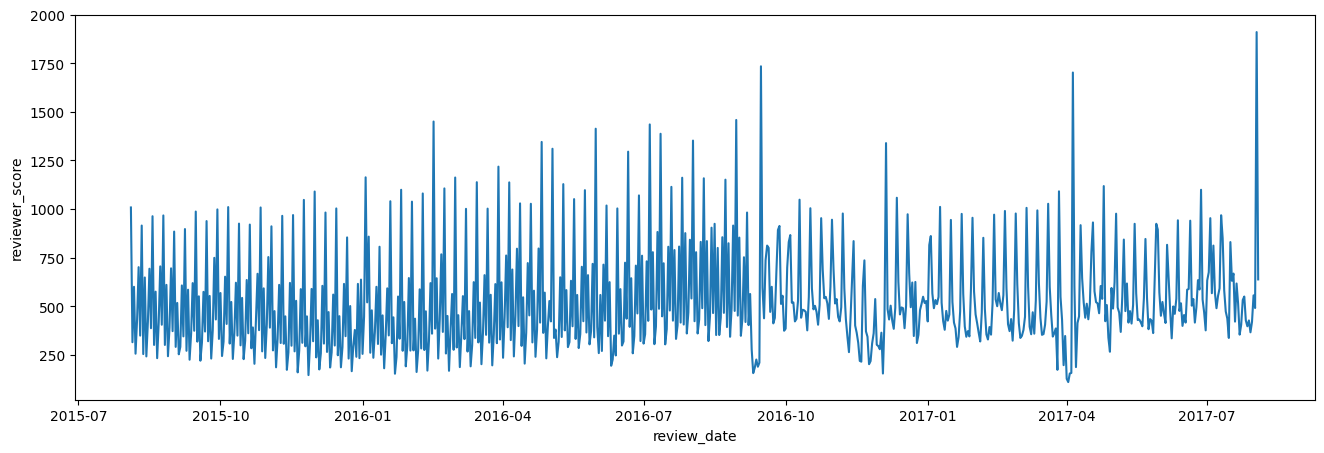

In [521]:
import matplotlib.pyplot as plt
import seaborn as sns

date = hotels.groupby('review_date')['reviewer_score'].count()
fig = plt.figure(figsize=(16, 5))
sns.lineplot(data=date)

Dates

<AxesSubplot: xlabel='review_date', ylabel='reviewer_score'>

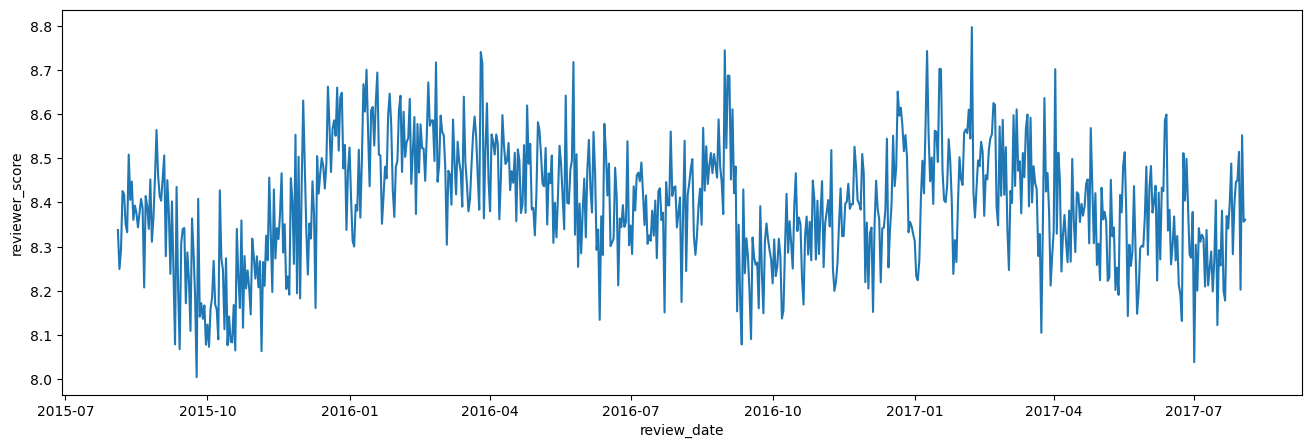

In [522]:
date2 = hotels.groupby('review_date')['reviewer_score'].mean()
fig = plt.figure(figsize=(16, 5))
sns.lineplot(data=date2)

Dates2

<AxesSubplot: xlabel='reviewer_score', ylabel='Count'>

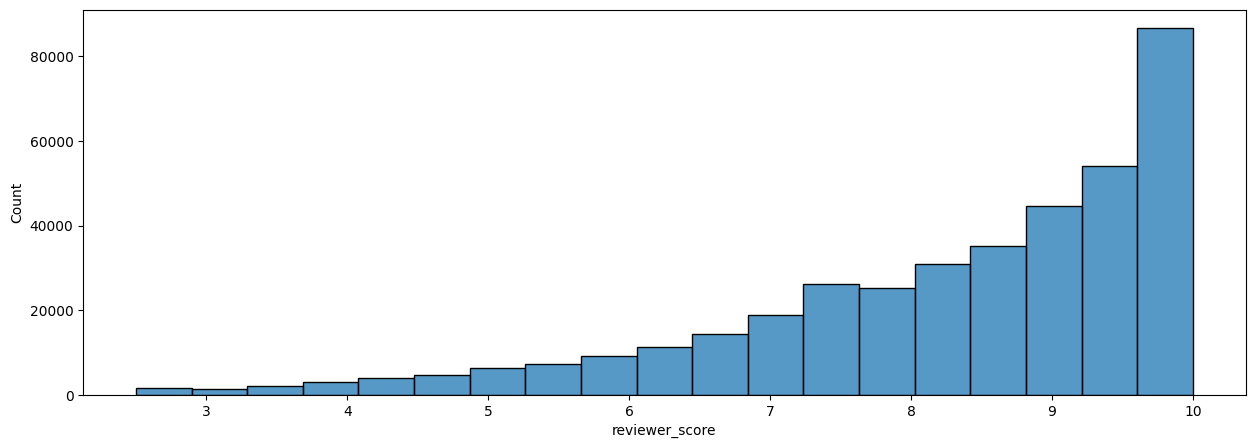

In [523]:
fig = plt.figure(figsize=(15,5))
sns.histplot(data=hotels,x='reviewer_score', bins=19)

In [524]:
country = pd.read_csv('data/country-codes.csv')

In [525]:
country = country.drop(columns=country.iloc[:, 6:]) 
country = country.drop(columns=country.iloc[:, 3:5])
country = country.drop(columns=country.iloc[:, 0:2]) 
country.head()

,ISO3166-1-Alpha-3,ISO3166-1-numeric
0,TWN,158.0
1,AFG,4.0
2,ALB,8.0
3,DZA,12.0
4,ASM,16.0


In [526]:
hotels = hotels.merge(country, left_on='country_code', right_on='ISO3166-1-Alpha-3', how='left')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386492 entries, 0 to 386491
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                386492 non-null  int64         
 1   review_date                                 386492 non-null  datetime64[ns]
 2   average_score                               386492 non-null  float64       
 3   hotel_name                                  386492 non-null  object        
 4   negative_review                             386492 non-null  object        
 5   review_total_negative_word_counts           386492 non-null  int64         
 6   total_number_of_reviews                     386492 non-null  int64         
 7   positive_review                             386492 non-null  object        
 8   review_total_positive_word_counts           386492 non-null  int64        

In [528]:
hotels['ISO3166-1-numeric'] = hotels['ISO3166-1-numeric'].astype(int)

826    184347
840     26494
36      16216
372     11119
784      7612
        ...  
184         1
535         1
728         1
798         1
308         1
Name: ISO3166-1-numeric, Length: 217, dtype: int64

In [529]:
hotels = hotels.rename(columns={'ISO3166-1-Alpha-3': 'reviewer_country_code', 'ISO3166-1-numeric': 'reviewer_country_numeric_code'})

In [530]:
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%Y%m%d').dt.strftime('%Y%m%d')

In [531]:
hotels['review_date'] = hotels['review_date'].astype(int)

In [532]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 386492 entries, 0 to 386491
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386492 non-null  int64  
 1   review_date                                 386492 non-null  int32  
 2   average_score                               386492 non-null  float64
 3   hotel_name                                  386492 non-null  object 
 4   negative_review                             386492 non-null  object 
 5   review_total_negative_word_counts           386492 non-null  int64  
 6   total_number_of_reviews                     386492 non-null  int64  
 7   positive_review                             386492 non-null  object 
 8   review_total_positive_word_counts           386492 non-null  int64  
 9   total_number_of_reviews_reviewer_has_given  386492 non-null  int64  
 

In [ ]:
# # убираем признаки которые еще не успели обработать, 
# # модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)

# заполняем пропуски самым простым способом
hotels = hotels.fillna(0)

In [ ]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']  

In [ ]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [ ]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
# Для тестирования мы будем использовать 25 % от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)

In [ ]:
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train) 
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.135890471944152
